In [2]:
%pip install liac-arff

  Preparing metadata (setup.py) ... done
  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11717 sha256=53c06781e98038133a6fb642ae48f5d846a253fa89c087357ee47ae3241091f7
  Stored in directory: /Users/abdelkrimzitouni/Library/Caches/pip/wheels/00/23/31/5e562fce1f95aabe57f2a7320d07433ba1cd152bcde2f6a002
Successfully built liac-arff
Note: you may need to restart the kernel to use updated packages.


In [16]:
!gunzip -c ./ALOI/aloi-8d.csv.gz > ./ALOI/aloi-8d.csv
!gunzip -c ./ALOI/aloi-haralick-1.csv.gz > ./ALOI/aloi-haralick-1.csv
!gunzip -c ./ALOI/aloi-hsb-2x2x2.csv.gz > ./ALOI/aloi-hsb-2x2x2.csv

In [1]:
import os
import numpy as np
import pandas as pd
import arff

def read_aloi_directory(directory):
    file_list = os.listdir(directory)
    dataset_list = []
    last_column_values = []
    objs = arff.load(open(directory+'/objs.arff'))
    labels = np.array(objs['data'])
    sorted_labels = labels[np.argsort(labels[:, -1].astype(str))]
    sorted_labels[:, :-1] = sorted_labels[:, :-1].astype(float)
    last_column_label_values = sorted_labels[:, -1]
    for file in file_list:
        file_path = os.path.join(directory, file)
        
        if file.endswith('.csv'):
            df = pd.read_csv(file_path, delimiter=' ', header=None)
            df = df.dropna(axis=1, how='all')
            data = df.values
        elif file == "aloi-colorsim77.arff":
            dataset = arff.load(open(file_path))
            data = np.array(dataset['data'])
        else:
            continue
        
        sorted_dataset = data[np.argsort(data[:, -1].astype(str))]
        last_column_values = sorted_dataset[:, -1]
        
        if np.all(last_column_values == last_column_label_values):
            dataset_list.append(sorted_dataset)
    
    dataset_list.append(sorted_labels)
    return dataset_list


In [9]:
aloi = read_aloi_directory('./ALOI')

In [12]:
len(aloi)

5

In [15]:
os.makedirs('aloi_csv', exist_ok=True)
# Save each array as a CSV file
for i, arr in enumerate(aloi):
    df = pd.DataFrame(arr)
    # df = df.apply(pd.to_numeric, errors='ignore')
    arr = df.to_numpy()
    filename = f'aloi_csv/aloi_array_{i}.csv'
    print(i)
    np.savetxt(filename, arr, delimiter=',', fmt='%s')


0
1
2
3
4


In [29]:
mv_dataset_files = os.listdir("./aloi_csv")
mv_dataset_files.sort()
dataset = []
for file in mv_dataset_files:
    df = pd.read_csv(f"./aloi_csv/{file}", header=None)
    numerical_df = df.select_dtypes(include=[np.number])
    dataset.append(numerical_df.to_numpy())

dataset

[array([[8.86246293e-01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 2.13464808e-02, 1.41262478e-02],
        [8.90708641e-01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.85275608e-02, 1.68773510e-02],
        [8.92001682e-01, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 1.45331489e-02, 2.14549877e-02],
        ...,
        [9.85243056e-01, 4.36288339e-04, 3.25520833e-04, ...,
         0.00000000e+00, 1.23652705e-03, 1.18295175e-02],
        [9.85206887e-01, 5.53837529e-04, 4.06901042e-04, ...,
         3.61689815e-05, 1.47614656e-03, 1.12734194e-02],
        [9.85866970e-01, 6.12612124e-04, 6.87210648e-04, ...,
         2.48661748e-05, 1.38346354e-03, 1.03194625e-02]]),
 array([[0.52106334, 0.5549817 , 0.55797701, ..., 0.65483649, 0.59232047,
         0.51372448],
        [0.51680537, 0.55127803, 0.55560497, ..., 0.65723221, 0.59390096,
         0.51455813],
        [0.51327497, 0.54751493, 0.55261007, ..., 0.6617243 , 0.59765731,

In [1]:
import numpy as np
import os


In [19]:
corel_directory = "./corel+image+features"
file_list = os.listdir(corel_directory)
dataset_list = []
for file in file_list:
    file_path = os.path.join(corel_directory, file)
    
    if file.endswith('.asc') and file != 'LayoutHistogram.asc':
        print(file)
        data = np.loadtxt(file_path)
        dataset_list.append(data[:, 1:])
        print(data.shape)

ColorMoments.asc
(68040, 10)
CoocTexture.asc
(68040, 17)
ColorHistogram.asc
(68040, 33)


In [62]:
import numpy as np
import scipy.sparse as sp

def load_data(sample, views):
    data = []
    for view in views:
        mtx_file = f"./ReutersEN/reutersEN/reutersEN_{sample}_{view}.mtx"
        maprow_file = f"./ReutersEN/reutersEN/reutersEN_{sample}_{view}.maprow.txt"
        mapcol_file = f"./ReutersEN/reutersEN/reutersEN_{sample}_{view}.mapcol.txt"
        
        # Load documents-words matrix
        with open(mtx_file, 'r') as f:
            # Skip header lines
            for _ in range(2):
                next(f)

            # Read matrix dimensions and number of non-zero entries
            num_rows, num_cols, num_entries = map(int, next(f).split())

            row_indices = []
            col_indices = []
            data_values = []

            # Read each line in the file and extract row index, column index, and data value
            for line in f:
                row, col, val = map(float, line.split())
                row_indices.append(int(row) - 1)  # Convert to 0-based indexing
                col_indices.append(int(col) - 1)  # Convert to 0-based indexing
                data_values.append(val)

            # Construct the sparse matrix
            sparse_mtx = sp.coo_matrix((data_values, (row_indices, col_indices)), shape=(num_rows, num_cols))
            dense_array = sparse_mtx.toarray()
            data.append(dense_array)
    
    return data

def load_labels():
    labels_file = "./ReutersEN/reutersEN/labels.txt"
    with open(labels_file, 'r') as f:
        labels = [line.strip() for line in f]
    return labels

def load_affectations():
    act_file = "./ReutersEN/reutersEN/reutersEN_act.txt"
    with open(act_file, 'r') as f:
        affectations = [line.strip() for line in f]
    return affectations

sample = 1
views = ['EN', 'FR', 'GR', 'IT', 'SP']

# Load data
data = load_data(sample, views)

# Load labels
labels = load_labels()

# Load affectations
affectations = load_affectations()

# Display loaded data
print("Loaded data:", data)
print("\nLabels:", labels)
print("\nAffectations:", affectations)


Loaded data: [array([[1.361033, 1.719371, 8.339537, ..., 0.      , 0.      , 0.      ],
       [0.937685, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.881949, 0.953139, 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]]), array([[1.361033, 1.719371, 8.339537, ..., 0.      , 0.      , 0.      ],
       [0.937685, 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       ...,
       [0.881949, 0.953139, 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ],
       [0.      , 0.      , 0.      , ..., 0.      , 0.      , 0.      ]]), array([[1.361033, 1.719371, 8.339537, ..., 0.      , 0.      , 0.     

# ------------

In [2]:
import cv2
import os
import numpy as np
from skimage.feature import hog
from skimage import feature
from skimage.filters import gabor_kernel
from scipy import ndimage
from mahotas.features import zernike_moments
from mahotas.features import haralick
from sklearn.decomposition import PCA

def extract_hog_features(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute HOG features
    features, _ = hog(gray, orientations=9, pixels_per_cell=(32, 32), cells_per_block=(2, 2), visualize=True, feature_vector=True)
    return features

def extract_lbp_features(image, bins=8, eps = 1e-7):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Compute LBP features
    lbp = feature.local_binary_pattern(gray, P=8, R=1, method='uniform')
    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, bins))

    # Normalize the histogram
    hist = hist.astype('float')
    hist /= (hist.sum() + eps)

    return hist, lbp

def extract_color_histogram(image, bins=(8, 8, 8)):
    hist = cv2.calcHist([image], [0, 1, 2], None, bins, [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    return hist

sift = cv2.SIFT_create()

def extract_sift_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    return descriptors

# surf = cv2.xfeatures2d.SURF_create()

# def extract_surf_features(image):
#     gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     keypoints, descriptors = surf.detectAndCompute(gray, None)
#     return descriptors

# texture
def extract_gabor_features(image, frequencies=[0.1, 0.5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filters = []
    ksize = 31
    for lambd in frequencies:
        for theta in angles:
            kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, lambd, 0.5, 0, ktype=cv2.CV_32F)
            kern /= 1.5*kern.sum()
            filters.append(kern)
            
    def process(img, filters):
        accum = np.zeros_like(img)
        for kern in filters:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            np.maximum(accum, fimg, accum)
            return accum

    features=process(gray,filters)
    return features

def exctract_glcm_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    graycom = feature.graycomatrix(gray, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256)
    # Find the GLCM properties
    contrast = feature.graycoprops(graycom, 'contrast')
    dissimilarity = feature.graycoprops(graycom, 'dissimilarity')
    homogeneity = feature.graycoprops(graycom, 'homogeneity')
    energy = feature.graycoprops(graycom, 'energy')
    correlation = feature.graycoprops(graycom, 'correlation')
    ASM = feature.graycoprops(graycom, 'ASM')
    contrast = contrast.flatten()
    dissimilarity = dissimilarity.flatten()
    homogeneity = homogeneity.flatten()
    energy = energy.flatten()
    correlation = correlation.flatten()
    ASM = ASM.flatten()

    features = np.concatenate((contrast, dissimilarity, homogeneity, energy, correlation, ASM), axis=0) 
    return features
    

def extract_zernike_moments(image, radius=21, degree=8):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    return zernike_moments(gray, radius, degree)

def extract_hu_moments(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    moments = cv2.moments(gray)
    hu_moments = cv2.HuMoments(moments)
    return np.concatenate(hu_moments)

orb = cv2.ORB_create()

def extract_orb_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    return descriptors


def extract_eigenfaces_features(image, num_components=50):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    flattened_image = gray.flatten()
    
    pca = PCA(n_components=num_components)
    pca.fit(flattened_image.reshape(1, -1))
    
    return pca.components_.flatten()


def extract_haralick_features(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    textures = haralick(gray)
    return textures.mean(axis=0)

In [3]:
def compute_features(image):
    color_histogram = extract_color_histogram(image)
    hog_features = extract_hog_features(image)
    lbp_hist, lbp_features = extract_lbp_features(image)
    glcm_features = exctract_glcm_features(image)
    zernike_moments = extract_zernike_moments(image)
    hu_moments = extract_hu_moments(image)
    haralick_features = extract_haralick_features(image)
    return [color_histogram.flatten(), hog_features.flatten(), lbp_hist.flatten(), glcm_features, zernike_moments.flatten(), hu_moments.flatten(), haralick_features.flatten()]

def read_images(dataset_path, start_id=1):
    multiview_dataset = {
        'Color Histogram': [],
        'HOG': [],
        'LBP': [],
        'GLCM Features': [],
        'Zernike Moments': [],
        'Hu Moments': [],
        'Haralick Texture': []
    }
    labels = {}
    id = start_id
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            img = cv2.imread(image_path)
            resized_image = cv2.resize(img, (224, 224))
            features = compute_features(resized_image)
            multiview_dataset['Color Histogram'].append(features[0])
            multiview_dataset['HOG'].append(features[1])    
            multiview_dataset['LBP'].append(features[2])
            multiview_dataset['GLCM Features'].append(features[3])
            multiview_dataset['Zernike Moments'].append(features[4])
            multiview_dataset['Hu Moments'].append(features[5])
            multiview_dataset['Haralick Texture'].append(features[6])
            labels.update({id: class_name})
            id += 1
    return multiview_dataset, labels

# Example usage:
train_set_path = "./corel/training_set"
multiview_train_set, train_labels = read_images(train_set_path)
test_set_path = "./corel/test_set"
multiview_test_set, test_labels = read_images(test_set_path, len(train_labels) + 1)


In [6]:
len(multiview_train_set["LBP"] + multiview_test_set["LBP"]), len(list(train_labels.keys()) + list(test_labels.keys()))

(1000, 1000)

In [10]:
# Convert to numpy arrays
multiview_dataset = {}
for k, v in multiview_train_set.items():
    multiview_dataset[k] = multiview_train_set[k] + multiview_test_set[k]
    multiview_dataset[k] = np.array(multiview_dataset[k])
    labels_keys = list(train_labels.keys()) + list(test_labels.keys())
    labels_keys = np.array(labels_keys)
    print(multiview_dataset[k].shape, labels_keys.shape)
    multiview_dataset[k] = np.insert(multiview_dataset[k], 0, labels_keys, axis=1)

(1000, 512) (1000,)
(1000, 1296) (1000,)
(1000, 7) (1000,)
(1000, 24) (1000,)
(1000, 25) (1000,)
(1000, 7) (1000,)
(1000, 13) (1000,)


In [11]:
for k, v in multiview_dataset.items():
    print(k, v.shape)

Color Histogram (1000, 513)
HOG (1000, 1297)
LBP (1000, 8)
GLCM Features (1000, 25)
Zernike Moments (1000, 26)
Hu Moments (1000, 8)
Haralick Texture (1000, 14)


In [17]:
import pandas as pd
os.makedirs('corel_features', exist_ok=True)
# Save each array as a CSV file
for k, v in multiview_dataset.items():
    df = pd.DataFrame(v)
    # df = df.apply(pd.to_numeric, errors='ignore')
    arr = df.to_numpy()
    filename = f'corel_features/{k}.csv'
    print(k)
    np.savetxt(filename, arr, delimiter=',', fmt='%s')

keys = np.array(list(train_labels.keys()))
vals = np.array(list(train_labels.values()), dtype=object)
array = np.column_stack((keys, vals))
array.shape, array
np.savetxt("corel_features/labels.txt", array, delimiter=' ', fmt='%s')


Color Histogram
HOG
LBP
GLCM Features
Zernike Moments
Hu Moments
Haralick Texture


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [16]:
mnist1_files_path = os.listdir("./MNIST_1")
mnist1_files_path.sort()
dataset = []
labels = []
for file in mnist1_files_path:
    view = []
    class_names = []
    with open(f"./MNIST_1/{file}", 'r') as f:
        for line in f.readlines():
            arr = line.split()
            class_names.append(arr[0])
            view.append([l.split(':')[1] for l in arr[1:]])
    dataset.append(np.array(view, dtype='int'))
    labels = np.array(class_names, dtype='str')


In [26]:
from sklearn.preprocessing import LabelEncoder
label_mapping = {"zero": 0, "one": 1, "two": 2, "three": 3, "four": 4,
                 "five": 5, "six": 6, "seven": 7, "eight": 8, "nine": 9}
elabels = np.array([label_mapping[label] for label in labels])

In [27]:
elabels, labels

(array([0, 0, 0, ..., 9, 9, 9]),
 array(['zero', 'zero', 'zero', ..., 'nine', 'nine', 'nine'], dtype='<U5'))

In [28]:
idx = 8400
labels[idx]

'one'

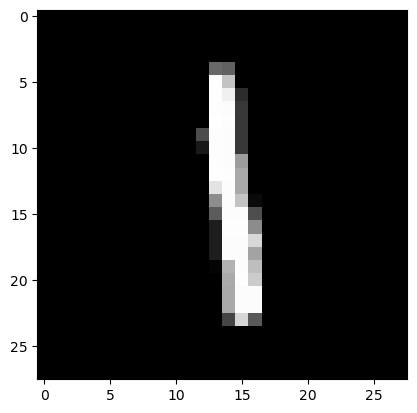

In [29]:
top = np.hstack((dataset[0][idx].reshape(14, 14), dataset[1][idx].reshape(14, 14)))
bottom = np.hstack((dataset[2][idx].reshape(14, 14), dataset[3][idx].reshape(14, 14)))
img = np.vstack((top, bottom))
plt.imshow(img, cmap="gray")

In [119]:
labels

array(['zero', 'zero', 'zero', ..., 'nine', 'nine', 'nine'], dtype='<U5')

In [113]:
mnist2_files_path = os.listdir("./MNIST_2")
mnist2_files_path.sort()
dataset2 = []
labels2 = []
for file in mnist2_files_path:
    view = []
    class_names = []
    with open(f"./MNIST_2/{file}", 'r') as f:
        for line in f.readlines():
            arr = line.split()
            class_names.append(arr[0])
            view.append([l.split(':')[1] for l in arr[1:]])
    dataset2.append(np.array(view, dtype='int'))
    labels2.append(np.array(class_names, dtype='object'))

In [2]:
nus_features_files_path = os.listdir("./NUS-WIDE-OBJECT/low level features")
nus_features_files_path.sort()
nus_labels_files_path = os.listdir("./NUS-WIDE-OBJECT/ground truth")
nus_labels_files_path.sort()

In [102]:
y_train, y_test = [], []
train_set, test_set = [], []

for file in  nus_features_files_path:
    view = file.split('_')[1].split('.')[0]
    with open(f"./NUS-WIDE-OBJECT/low level features/{file}", 'r') as f:
        data = []
        for line in f.readlines():
            data.append([float(x) for x in line.split()])
        if 'Train' in file:
            train_set.append(np.array(data))
        else:
            test_set.append(np.array(data))
        views.append(view)

for file in nus_labels_files_path:
    with open(f"./NUS-WIDE-OBJECT/ground truth/{file}", 'r') as f:
        data = []
        for line in f.readlines():
            data.append(int(line))
        if 'Train' in file:
            y_train.append(data)
        else:  
            y_test.append(data)

# dataset = train_set
# dataset.extend(test_set)
labels = np.concatenate([y_train, y_test], axis=1).transpose()

# Remove labels with less than min_pos_samples positive samples
selected_labels = np.where(labels.sum(axis=0) > 2000)[0]
labels = labels[:, selected_labels]

In [104]:
dataset = []
for xtr, xts in zip(train_set, test_set):
    dataset.append(np.concatenate([xtr, xts], axis=0))

In [105]:
len(dataset)

5

In [4]:
import pandas as pd

In [43]:
fash1_files_paths = os.listdir("./EMNIST_Letters_1")
fash1_files_paths.sort()

fash_mv = []
v1, v2, v3, v4 = [], [], [], []
labels = []
for file in fash1_files_paths:
    if file.endswith('.csv'):
        df = pd.read_csv(f"./EMNIST_Letters_1/{file}")
        y = df.iloc[:, 0].values
        labels.append(y)
        for row in df.iloc[:, 1:].values:
            img = row.reshape(28, 28)
            r,c = img.shape
            v1.append(img[:r//2, :c//2].flatten())
            v2.append(img[:r//2, c//2:].flatten())
            v3.append(img[r//2:, :c//2].flatten())
            v4.append(img[r//2:, c//2:].flatten())
fash_mv.append(np.array(v1, dtype='int'))
fash_mv.append(np.array(v2, dtype='int'))
fash_mv.append(np.array(v3, dtype='int'))
fash_mv.append(np.array(v4, dtype='int'))
labels = np.concatenate(labels, axis=0)
for i, v in enumerate(fash_mv):
    view = np.column_stack((labels, v))
    np.savetxt(f'./EMNIST_Letters_1/view{i}', view, delimiter=' ', fmt='%s')

In [46]:
def generate_overlapping_views(image):
    views = []
    height, width = image.shape

    # Define the size of the overlapping region
    overlap_size = 14

    # Define the starting point for the overlapping views
    start_row = (height - overlap_size) // 2
    start_col = (width - overlap_size) // 2

    # Generate four overlapping views around the center
    for row_shift in [-4, 4]:
        for col_shift in [-4, 4]:
            view = image[start_row + row_shift:start_row + row_shift + overlap_size,
                         start_col + col_shift:start_col + col_shift + overlap_size]
            views.append(view.flatten())
    
    return views

In [47]:
fash1_files_paths = os.listdir("./EMNIST_Letters_2")
fash1_files_paths.sort()

fash_mv = []
v1, v2, v3, v4 = [], [], [], []
labels = []
for file in fash1_files_paths:
    if file.endswith('.csv'):
        df = pd.read_csv(f"./EMNIST_Letters_2/{file}")
        y = df.iloc[:, 0].values
        labels.append(y)
        for row in df.iloc[:, 1:].values:
            img = row.reshape(28, 28)
            views = generate_overlapping_views(img)
            v1.append(views[0])
            v2.append(views[1])
            v3.append(views[2])
            v4.append(views[3])
fash_mv.append(np.array(v1, dtype='int'))
fash_mv.append(np.array(v2, dtype='int'))
fash_mv.append(np.array(v3, dtype='int'))
fash_mv.append(np.array(v4, dtype='int'))
labels = np.concatenate(labels, axis=0)
for i, v in enumerate(fash_mv):
    view = np.column_stack((labels, v))
    np.savetxt(f'./EMNIST_Letters_2/view{i+1}', view, delimiter=' ', fmt='%s')

In [2]:
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder

In [10]:
mushroom = pd.read_csv("./Mushroom/mushrooms.csv")
mushroom

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8119,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8120,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8121,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8122,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [11]:
data_encoded = mushroom.copy()
le = LabelEncoder()
for col in data_encoded.columns:
    data_encoded[col] = le.fit_transform(data_encoded[col]) 
    
data_encoded.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,1,5,2,4,1,6,1,0,1,4,...,2,7,7,0,2,1,4,2,3,5
1,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
2,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
3,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
4,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1


In [12]:
data_encoded.columns

Index(['class', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat'],
      dtype='object')

In [16]:
v1_columns = ['cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor',
       'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color',
       'population', 'habitat']
v2_columns = ['stalk-shape', 'stalk-root', 'stalk-surface-above-ring',
       'stalk-surface-below-ring', 'stalk-color-above-ring',
       'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number',
       'ring-type', 'spore-print-color', 'population', 'habitat']
view1 = data_encoded[v1_columns]
view2 = data_encoded[v2_columns]
labels = data_encoded['class']

In [17]:
view1.to_csv("./Mushroom/view1.csv", index=False)
view2.to_csv("./Mushroom/view2.csv", index=False)
labels.to_csv("./Mushroom/labels", index=False)

In [3]:
import pyfeats

In [5]:
ptbxl_path = "./PTB-XL-plus/"
ptbxl_files_paths = os.listdir(ptbxl_path)


In [96]:
import pandas as pd
import numpy as np
import ast

# load and convert annotation data

Y = pd.read_csv(ptbxl_path+'labels/ptbxl_statements.csv', index_col='ecg_id')
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))
Y.scp_codes = Y.scp_codes.apply(lambda x: dict(x))

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(ptbxl_path+'labels/scp_statements.csv', index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]

def aggregate_diagnostic(y_dic):
    tmp = []
    
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

# Apply diagnostic superclass
Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic).astype('str')


labels = Y.diagnostic_superclass


<Axes: title={'center': 'Diagnostic superclass distribution'}, xlabel='diagnostic_superclass'>

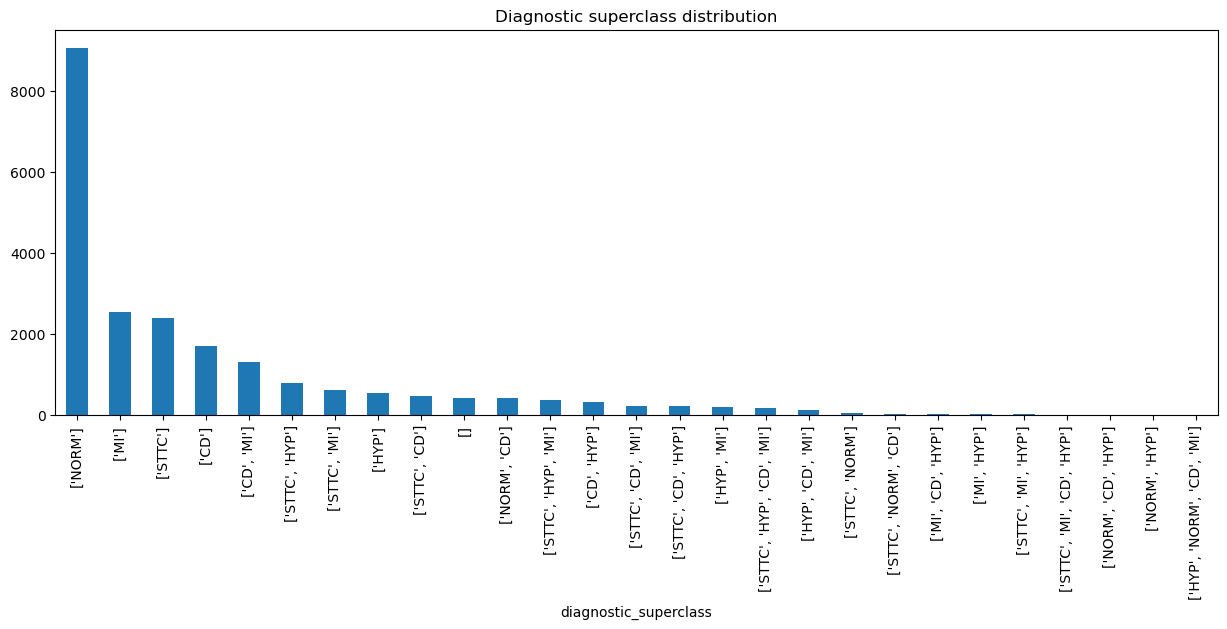

In [97]:
labels.value_counts().plot(kind='bar', title='Diagnostic superclass distribution', figsize=(15, 5))

In [99]:
labels.iloc[np.where(labels.values == "['NORM']")].value_counts()

diagnostic_superclass
['NORM']    9069
Name: count, dtype: int64

In [1]:
import pandas as pd
import numpy as np
import os
from sklearn.impute import KNNImputer

def train_test_split(Xs, labels, test_size=0.2, random_state=42):

    num_views = len(Xs)
    num_samples = len(labels)

    # Shuffle the indices
    indices = np.arange(num_samples)
    np.random.seed(random_state)
    np.random.shuffle(indices)

    # Split data and labels
    split_index = int(num_samples * test_size)
    test_indices, train_indices = indices[:split_index], indices[split_index:]

    Xs_train = [view[train_indices] for view in Xs]
    y_train = labels[train_indices]

    Xs_test = [view[test_indices] for view in Xs]
    y_test = labels[test_indices]

    return Xs_train, y_train, Xs_test, y_test

In [3]:
class PTB_XL_plus:
    def __init__(self, dataset_path = os.getcwd()+'/PTB-XL-plus/'):
        self._name = "PTB-XL+"
        self.dataset_path = dataset_path
        self.filenames = os.listdir(dataset_path)
        self.rate_missing_values = 0.5

    def load_data(self):
        dataset = []
        for file in self.filenames:
            if file.endswith('.csv'):
                data = pd.read_csv(self.dataset_path+file, index_col='ecg_id')
                data.sort_values(by='ecg_id', inplace=True)
                dataset.append(data)
            else:
                labels = pd.read_csv(self.dataset_path+file, index_col='ecg_id')
                labels.sort_values(by='ecg_id', inplace=True)

        # Merge all dataframes on the index (ecg_id)
        merged_df = pd.merge(dataset[0], dataset[1], on='ecg_id')
        for df in dataset[2:]:
            merged_df = pd.merge(merged_df, df, on='ecg_id')

        for i, data in enumerate(dataset):
            dataset[i] = data.loc[merged_df.index] #.dropna(axis=1)

        # Extract the labels
        labels = labels.loc[merged_df.index]
        return dataset, labels

    def clear_missing_values(self, dataset):
        for i, view in enumerate(dataset):
            numerical_cols = view.select_dtypes(include=[np.number, 'float']).columns
            nan_cols = []
            print(f"View {i}:")
            for col in view.columns:
                missing_rate = view[col].isna().sum() / len(view.index)
                if missing_rate >= self.rate_missing_values or view[col].nunique(col) == 1:
                    # print(f"\t\t {col} with missing rate {missing_rate}")
                    dataset[i] = dataset[i].drop(col, axis=1)
                else:
                    if col in numerical_cols:
                        # print(f"\t\t\t\t {col} with missing rate {missing_rate}")
                        nan_cols.append(col)
                        column = dataset[i][col]
                        dataset[i][col] = column.fillna(column.median())

    def get_data(self, **kwargs):
        Xs, y = self.load_data()
        self.clear_missing_values(Xs)
        # Xs_train, y_train, Xs_test, y_test = train_test_split(Xs, y)
        return Xs, y

In [4]:
dataset = PTB_XL_plus()
# Xs_train, y_train, Xs_test, y_test = dataset.get_data()
Xs, y = dataset.get_data()

View 0:
View 1:
View 2:


In [5]:
for i, view in enumerate(Xs):
    print(f"View {i+1}: {view.shape}, {view.isna().sum().sum()} missing values")
    assert np.all(view.index == y.index)


View 1: (21795, 782), 0 missing values
View 2: (21795, 529), 0 missing values
View 3: (21795, 712), 0 missing values


In [5]:
view = Xs[0]
numerical_cols = view.select_dtypes(include=[np.number, 'float']).columns
nan_cols=[]
for col in view.columns:
    missing_rate = view[col].isna().sum() / len(view.index)
    if missing_rate >= 0.5 or view[col].nunique(col) == 1:
        print(f"{col} with missing rate {missing_rate}")
        # Xs[0] = view.drop(col, axis=1)
    else:
        if col in numerical_cols:
            nan_cols.append(col)

In [16]:
len(nan_cols)

782

In [135]:
for i, view in enumerate(Xs):
    print(f"View {i+1}: {view.shape}, {view.isna().sum().sum()} missing values")
    assert np.all(view.index == y.index)

View 1: (21795, 782), 11674 missing values
View 2: (21795, 531), 286560 missing values
View 3: (21795, 748), 721034 missing values


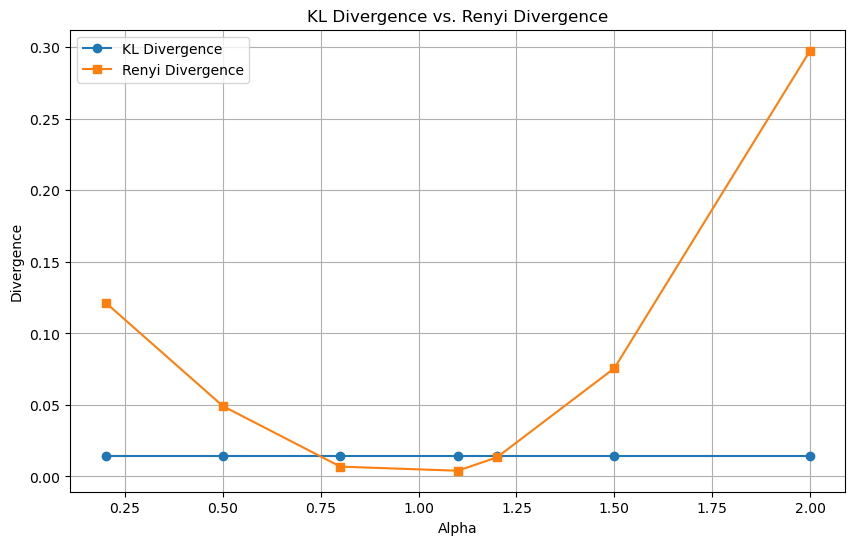

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

def kl(Q, P):
    """
    Compute the Kullback-Leibler (KL) divergence between two probability distributions Q and P.
    
    Args:
        Q (torch.Tensor): The first probability distribution.
        P (torch.Tensor): The second probability distribution.
    
    Returns:
        torch.Tensor: The KL divergence between Q and P.
    """
    assert Q.size() == P.size(), "Distributions must have the same size"
    return F.kl_div(Q.log(), P, reduction='sum')

def renyi_divergence(Q, P, alpha):
    """
    Compute the Renyi divergence between two probability distributions.

    Args:
        Q (torch.Tensor): The first probability distribution.
        P (torch.Tensor): The second probability distribution.
        alpha (float): The parameter for Renyi divergence.

    Returns:
        torch.Tensor: The Renyi divergence between Q and P.
    """
    assert Q.size() == P.size(), "Distributions must have the same size"

    # Compute the Renyi divergence
    divergence = torch.log(torch.sum(torch.pow(P, alpha) * torch.pow(Q, 1 - alpha)))

    return divergence

# Define the distributions
p = torch.tensor([0.1, 0.6, 0.5])
q = torch.tensor([0.3, 0.4, 0.3])

# Define alpha values
alphas = [0.2, 0.5, 0.8, 1.1, 1.2, 1.5, 2]

# Compute KL divergence and Renyi divergence for each alpha
kl_divergences = []
renyi_divergences = []

for alpha in alphas:
    kl_div = kl(p, q)
    renyi_div = renyi_divergence(p, q, alpha)
    kl_divergences.append(kl_div.item())
    renyi_divergences.append(renyi_div.item())

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(alphas, kl_divergences, label='KL Divergence', marker='o')
plt.plot(alphas, renyi_divergences, label='Renyi Divergence', marker='s')
plt.xlabel('Alpha')
plt.ylabel('Divergence')
plt.title('KL Divergence vs. Renyi Divergence')
plt.legend()
plt.grid(True)
plt.show()
